In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import keras
import keras.backend as K

['test.csv', 'resources.csv', 'train.csv', 'sample_submission.csv']


Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2198643479038807748
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6367354577010767162
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15776417342204668642
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15882446439
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8470126755234405961
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [4]:
train_df = pd.read_csv("../input/train.csv")

In [5]:
train_df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [7]:
train_df["project_essay_1"].head()

0    Most of my kindergarten students come from low...
1    Our elementary school is a culturally rich sch...
2    Hello;\r\nMy name is Mrs. Brotherton. I teach ...
3    My students are the greatest students but are ...
4    My students are athletes and students who are ...
Name: project_essay_1, dtype: object

In [8]:
 train_df["project_essay_2"].head()

0    I currently have a differentiated sight word c...
1    We strive to provide our diverse population of...
2    We are looking to add some 3Doodler to our cla...
3    The student's project which is totally \"kid-i...
4    For some reason in our kitchen the water comes...
Name: project_essay_2, dtype: object

In [9]:
def get_proj_essay(df):
    return  df["project_essay_1"].fillna('')+" "+ df["project_essay_2"].fillna('')+ " "+ df["project_essay_3"].fillna('')+" "+ df["project_essay_4"].fillna('')+" "

In [10]:
get_proj_essay(train_df)

0         Most of my kindergarten students come from low...
1         Our elementary school is a culturally rich sch...
2         Hello;\r\nMy name is Mrs. Brotherton. I teach ...
3         My students are the greatest students but are ...
4         My students are athletes and students who are ...
5         My kids tell me each day that they want to mak...
6         Kindergarten is the new first grade. My studen...
7         First graders are fantastic! They are excited ...
8         My seventh graders dream big. They can't wait ...
9         I teach first grade in a small farming town in...
10        My classroom has 24 students in it. We have an...
11        My children come to school everyday with the s...
12        My school is located in a high poverty area, j...
13        Each day my fifth graders walk into our \"home...
14        The children at our school come from a variety...
15        My third graders are eager to learn new concep...
16        My students are Hispanics, Spa

In [11]:
def get_text(df):
    return df["project_title"].fillna('')+' '+get_proj_essay(df)

In [12]:
get_text(train_df)

0         Super Sight Word Centers Most of my kindergart...
1         Keep Calm and Dance On Our elementary school i...
2         Lets 3Doodle to Learn Hello;\r\nMy name is Mrs...
3         \"Kid Inspired\" Equipment to Increase Activit...
4         We need clean water for our culinary arts clas...
5         Need to Reach Our Virtual  Mentors!!! My kids ...
6         Active Kindergartners Kindergarten is the new ...
7         Fabulous Firsties-Wiggling to Learn! First gra...
8         Wobble Chairs Help Fidgety Kids Focus My seven...
9         Snuggle Up With A Good Book I teach first grad...
10        Writing, Writing, Writing! My classroom has 24...
11        Technology Boost! My children come to school e...
12        Life Lessons through Literacy My school is loc...
13        Extra! Extra! Read all about it!!  We love to ...
14        Flexible seating The children at our school co...
15        A Comfy Seat! My third graders are eager to le...
16        iPads for Bilingual Education 

In [13]:
train, dev = train_test_split(train_df, random_state=123, shuffle=True, test_size=0.1)
print("Training data shape:", train.shape)
print("Test data shape:", dev.shape)

Training data shape: (163872, 16)
Test data shape: (18208, 16)


In [14]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(get_text(train))

In [15]:
def preprocess_target(df):
    return df[["project_is_approved"]].copy()
def preprocess_data(df):
    processed_df = df[["teacher_number_of_previously_posted_projects"]].copy()
    processed_df["project_title"] = tokenizer.texts_to_sequences(df["project_title"])
    processed_df["project_essay"] = tokenizer.texts_to_sequences(get_proj_essay(df))    
    return processed_df

In [16]:
processed_train  = preprocess_data(train)
processed_target = preprocess_target(train)
processed_target.shape, processed_train.shape

((163872, 1), (163872, 3))

In [17]:
processed_dev  = preprocess_data(dev)
processed_dev_target = preprocess_target(dev)
processed_dev.shape, processed_dev_target.shape

((18208, 3), (18208, 1))

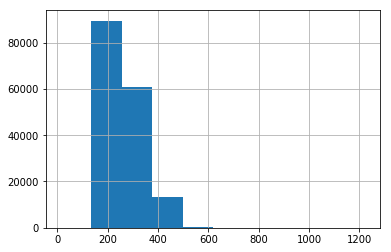

In [18]:
processed_train["project_essay"].apply(lambda x: len(x)).hist(bins=10)

In [19]:
processed_train["project_essay"].apply(lambda x: max(x) if len(x) > 0 else 0)

62891     20370
864        3137
152015    12185
42557     30086
147514     5202
31611     14739
6644      25789
5565      33552
48215     14040
64322     30087
6792      13516
82133     18553
120877    33553
101537    12744
18718     30089
11139     23071
130378    49357
19665     10663
80965     49358
123693    49359
49398     38889
160099    49360
155636    15833
59809     23072
133781    11147
126078    27657
24154     49361
8462      24310
142330    49364
110876    33555
          ...  
8028       5760
2428       9841
4195       8218
124777    27446
83079      6945
23728      8933
6648      16168
30255     24922
121428     3874
157698    25495
45507     22942
73521     82639
83012     13144
130256    26940
146016     6618
35662     11988
148819    16964
164782    10030
71200     82640
118857     7346
154238    20522
65632     10762
153313     7086
46203     12970
129130    15533
146449    21354
119906    82641
17730     26347
28030     35501
15725      9635
Name: project_essay, Len

In [20]:
MAX_PROJECT_TITLE_SEQ_LEN = 12
MAX_PROJECT_TITLE = processed_train["project_title"].apply(lambda x: max(x) if len(x) > 0 else 0).max() + 1

MAX_PROJECT_ESSAY_SEQ_LEN = 450
MAX_PROJECT_ESSAY = processed_train["project_essay"].apply(lambda x: max(x) if len(x) > 0 else 0).max() + 1

MAX_TEXT = max([MAX_PROJECT_TITLE, MAX_PROJECT_ESSAY])

In [21]:
MAX_TEXT

82642

In [22]:
def get_keras_data(df):
    return {
        "teacher_number_of_previously_posted_projects": np.array(df["teacher_number_of_previously_posted_projects"]),
        "project_title": keras.preprocessing.sequence.pad_sequences(df["project_title"], maxlen=MAX_PROJECT_TITLE_SEQ_LEN),
        "project_essay": keras.preprocessing.sequence.pad_sequences(df["project_essay"], maxlen=MAX_PROJECT_ESSAY_SEQ_LEN),
    }

X_train = get_keras_data(processed_train)
X_dev = get_keras_data(processed_dev)

In [23]:
def create_rnn_model():
    
    #Input Layers
    teacher_previous_projects = keras.layers.Input(shape=(1,), name = "teacher_number_of_previously_posted_projects")
    proj_title = keras.layers.Input(shape=(MAX_PROJECT_TITLE_SEQ_LEN,), name="project_title")
    proj_essay = keras.layers.Input(shape=(MAX_PROJECT_ESSAY_SEQ_LEN,), name = "project_essay")
    
    emb_layer = keras.layers.Embedding(MAX_TEXT,50)
    emb_project_title = emb_layer(proj_title)
    emb_project_essay = emb_layer(proj_essay)
    
    #RNN Layers
    rnn_project_title = keras.layers.GRU(8, activation = 'relu')(emb_project_title)
    rnn_project_essay = keras.layers.GRU(16, activation = 'relu')(emb_project_essay)
    
    all_layers = keras.layers.concatenate([teacher_previous_projects,
                                              rnn_project_title,
                                              rnn_project_essay])
    # Output layer
    rnn_output = keras.layers.Dense(1, activation = 'sigmoid')(all_layers)
    
    return keras.models.Model(
        inputs=[teacher_previous_projects,
                proj_title,
                proj_essay,
               ],
        output = rnn_output
    )
rnn_model = create_rnn_model()
rnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
project_title (InputLayer)      (None, 12)           0                                            
__________________________________________________________________________________________________
project_essay (InputLayer)      (None, 450)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             4132100     project_title[0][0]              
                                                                 project_essay[0][0]              
__________________________________________________________________________________________________
teacher_number_of_previously_po (None, 1)            0                                            
__________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [24]:
optimizer = keras.optimizers.Adam(lr=0.001)
rnn_model.compile(optimizer=optimizer,
                  loss=keras.losses.binary_crossentropy,
                  metrics=["accuracy"])

for i in range(3):
    rnn_model.fit(X_train, processed_target,
                 batch_size=(2 ** (i + 8)),
                 epochs=1,
                 validation_data=(X_dev, processed_dev_target))

Train on 163872 samples, validate on 18208 samples
Epoch 1/1
163872/163872 [==============================] - 361s 2ms/step - loss: 0.4200 - acc: 0.8479 - val_loss: 0.3786 - val_acc: 0.8459
Train on 163872 samples, validate on 18208 samples
Epoch 1/1
163872/163872 [==============================] - 176s 1ms/step - loss: 0.3607 - acc: 0.8523 - val_loss: 0.3711 - val_acc: 0.8500
Train on 163872 samples, validate on 18208 samples
Epoch 1/1
163872/163872 [==============================] - 90s 551us/step - loss: 0.3383 - acc: 0.8638 - val_loss: 0.3741 - val_acc: 0.8494


In [25]:
preds = rnn_model.predict(X_dev, batch_size=512)
auc_score = roc_auc_score(processed_dev_target, preds)
print("AUC for validation data: %.4f" % (auc_score,))

AUC for validation data: 0.7559
